# With Synthetic Data

In [ ]:
import os
PATH = os.getenv("HOME")
os.chdir(f"{PATH}/watttime-python-client-aer-algo")

import pandas as pd
import evaluation.eval_framework as evu
from datetime import datetime

import seaborn as sns
import evaluation.metrics as m

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

In [32]:
import random
import math

## Analysis Details
- 2024 dates only
- 1000 users
- sanity check on 9 current regions + 9 randomly selected other regions
- set of requery increments to test: none, 5,15,60,180
- charging windows of lengths 3,6,12 hours
- Charge needed at least 45 minutes (25% of smallest window)

### Dates + device characteristics

In [2]:
dates_2023 = evu.generate_random_dates(2023)
dates_2024 = evu.generate_random_dates(2024)
distinct_date_list = dates_2023 + dates_2024

In [3]:
dates_2024_only = list(filter(lambda x: x.year == 2024, distinct_date_list))

req_kwargs = {
    "power_output_max_rates": [42.5], # BMW average
    "max_percent_capacity": 0.95,  # highest level of charge achieved by battery
    "power_output_efficiency": 0.75,  # power loss. 1 = no power loss.
    "average_battery_starting_capacity": 0.5,  # average starting percent charged
    "start_hour": "00:00:00",  # earliest session can start
    "end_hour": "23:59:00",  # latest session can start
    "user_charge_tolerance":1, # must complete
    "session_lengths":[x*60*60 for x  in [3,6,12]] # convert hours to seconds
}

In [4]:
df_req = evu.execute_synth_data_process(
    distinct_date_list=dates_2024_only, number_of_users=1000, **req_kwargs
)

100%|██████████| 1000/1000 [00:03<00:00, 288.48it/s]


### Regions

In [ ]:
regions = [
    "CAISO_NORTH",
    "SPP_TX",
    "ERCOT_EASTTX",
    "FPL",
    "SOCO",
    "PJM_CHICAGO",
    "LDWP",
    "PJM_DC",
    "NYISO_NYC",
]

#from evaluation.config import MOER_REGION_LIST
#random_regions = random.sample([elem for elem in MOER_REGION_LIST if elem not in regions], 9)

random_regions = [
    'PACE',
    'PNM',
    'MISO_INDIANAPOLIS',
    'WALC',
    'SPP_FORTPECK',
    'SPP_KANSAS',
    'AECI',
    'BANC',
    'PJM_SOUTHWEST_OH'
]

<Axes: ylabel='Frequency'>

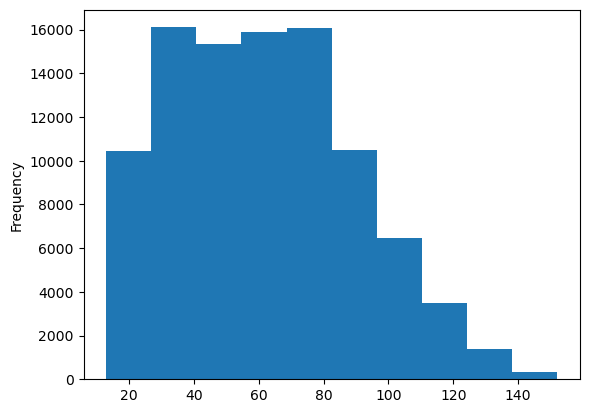

In [20]:
df_req.usage_time_required_minutes.plot(kind='hist')

In [25]:
df_req = df_req.query('usage_time_required_minutes > 45')

In [27]:
print(f"total sample frame will be: {df_req.shape[0]*18}")

total sample frame will be: 1149966


### Single test

In [29]:
synth_data = df_req.sample(1)

In [33]:
synth_data.T

,70603
index,43
distinct_dates,2024-06-02
user_type,r25.84_tc108_avglc24437_sdlc7318_contFalse
session_start_time,2024-06-02 06:40:05
session_end_time,2024-06-02 09:40:05
initial_charge,0.599488
total_seconds_to_95,5273.961966
full_charge_time,2024-06-02 08:07:58.961965919
length_of_session_in_seconds,10800.0
charged_kWh_actual,37.855327


In [34]:
optimization_method = "simple"
requery_intervals = [5,15,60,180]
region = "PJM_SOUTHWEST_OH"

def sanitize_time_needed(x,y):
    return int(math.ceil(min(x, y) / 300.0) * 5)

def sanitize_total_intervals(x):
    return math.ceil(x)

synth_data["moer_forecast"] = synth_data.apply(
    lambda x: evu.get_historical_fcst_data(
        x.session_start_time, 
        sanitize_total_intervals(x.total_intervals_plugged_in),
        region=region
    ),
    axis=1,
)

synth_data["moer_actual"] = synth_data.apply(
    lambda x: evu.get_historical_actual_data(
        x.session_start_time, 
        sanitize_total_intervals(x.total_intervals_plugged_in),
        region=region
    ),
    axis=1,
)


In [ ]:
schedule = efu.get_schedule_and_cost_api_requerying(
    region=region,
    usage_power_kw=synth_data.power_output_rate,
    time_needed=synth_data.sanitize_time_needed,
    start_time=synth_data.session_start_time,
    end_time=synth_data.session_end_time,
    optimization_method=optimization_method,
    moer_list=synth_data["moer_forecast"],
    ).reset_index()

In [ ]:
evu.get_schedule_and_cost_api(
            usage_power_kw=row.power_output_rate,
            time_needed=row.sanitize_time_needed,
            total_time_horizon=row.sanitize_intervals_plugged_in,
            moer_data=moer_data,
            optimization_method=optimization_method,
            charge_per_interval=charge_per_interval_func(row.sanitize_time_needed, contiguous=contiguous)
        )

In [ ]:
schedule = efu.get_schedule_and_cost_api_requerying(
    region=region,
    usage_power_kw=usage_power_kw,
    time_needed=time_needed,
    start_time=start_time,
    end_time=end_time,
    optimization_method=optimization_method,
    moer_list=moer_list,
    ).reset_index()

In [ ]:
increments = [0,5,15,60,180]